In [1]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/geom2vec/results/chignolin_stride10'
preprocess = Preprocessing(torch_or_numpy='torch')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r')
# we concatenate the data of the same trajectory
# we sum the token dim and we just use MLP in this tutorial
dataset = torch.cat(raw_dataset).sum(1).to(torch.float32)
del raw_dataset
time_lagged_dataset = preprocess.create_dataset(dataset.to(torch.float32), lag_time=10)
print(time_lagged_dataset[0][0].shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 57.06it/s]


torch.Size([4, 128])


In [2]:
from torch.utils.data.dataloader import DataLoader

train_data, val_data = torch.utils.data.random_split(time_lagged_dataset, [int(0.8*len(time_lagged_dataset)), len(time_lagged_dataset)-int(0.8*len(time_lagged_dataset))])

print('train_data:', len(train_data))
print('val_data:', len(val_data))

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

train_data: 42772
val_data: 10693


In [3]:
train_data[0][0].dtype

torch.float32

In [10]:
from geom2vec.downstream_models.lobe import Lobe
from geom2vec.downstream_models.vamp.vampnet import VAMPNet
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Lobe(
    hidden_channels=128,
    intermediate_channels=128,
    output_channels=2,
    num_layers=3,
    batch_norm=False,
    vector_feature=True,
    mlp_dropout=0.1,
    mlp_out_activation=None
).to(device)

model = VAMPNet(
    lobe=net,
    learning_rate=1e-3,
    device=device
)

model.fit(train_loader,n_epochs=10,validation_loader=val_loader,progress=tqdm)



epoch:  10%|██████████▉                                                                                                  | 1/10 [00:00<00:03,  2.61it/s]

0 1.901399850845337


epoch:  20%|█████████████████████▊                                                                                       | 2/10 [00:00<00:03,  2.66it/s]

1 1.91285240650177


epoch:  30%|████████████████████████████████▋                                                                            | 3/10 [00:01<00:02,  2.63it/s]

2 1.9137487411499023


epoch:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:01<00:02,  2.64it/s]

3 1.9170119762420654


epoch:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:01<00:01,  2.65it/s]

4 1.9228627681732178


epoch:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:02<00:01,  2.65it/s]

5 1.919364094734192


epoch:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:02<00:01,  2.65it/s]

6 1.9242273569107056


epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:03<00:00,  2.66it/s]

7 1.922573447227478


epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:03<00:00,  2.65it/s]

8 1.9214551448822021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 131.16it/s]
                                                                                                                                                        

9 1.9229563474655151


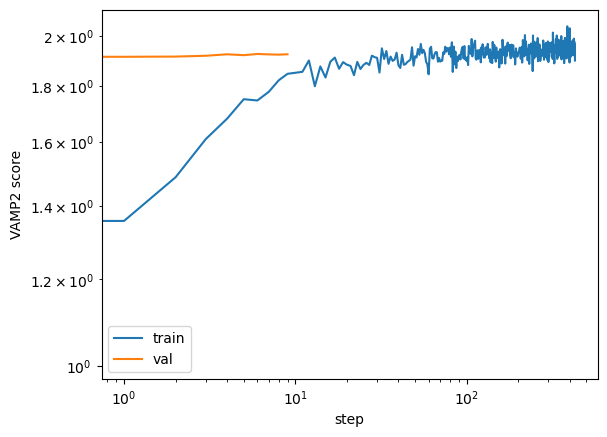

In [11]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('VAMP2 score')
plt.legend()
plt.show()

In [12]:
cvs = model.transform(dataset,return_cv=True,lag_time=10,batch_size=1000)
cvs.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1229.36it/s]


(53475, 2)

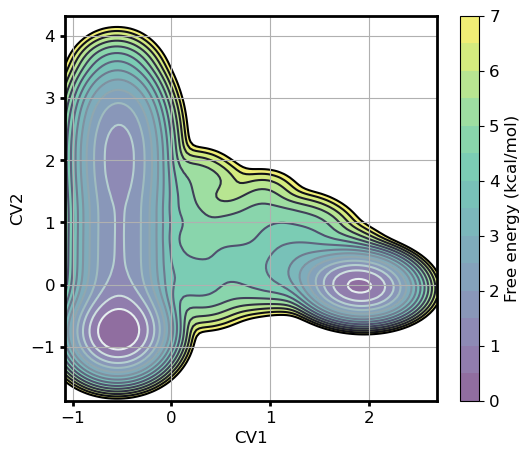

In [14]:
from geom2vec.utils import ContourPlot2D

fig,ax = plt.subplots(1,1,figsize=(6,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_tick_params(labelsize=12,direction='out',width=2)
ax.yaxis.set_tick_params(labelsize=12,direction='out',width=2)
c = ContourPlot2D()
ax = c.plot(cvs[:,0:2],ax,labelsize=12,xlabel='CV1',ylabel='CV2')

# don't just use that little data, use all the data